# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate

At first, we are loading some pre-defined parameters.

In [2]:
params = pd.read_csv("../../../sid/params.csv", index_col=["category", "name"])

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [3]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=10_000,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=10_000)

initial_states = pd.DataFrame({"age_group": age_group, "region": region})
initial_states.head(5)

,age_group,region
0,70 - 79,Gelderland
1,80 - 100,Overtjssel
2,40 - 49,Drenthe
3,30 - 39,Drenthe
4,20 - 29,Gelderland


For the simulation, we need at least one individual which is infected.

In [4]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(100, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [5]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)


contact_models = {
    "meet_distant": {"contact_type": "distant", "model": meet_distant,},
    "meet_close": {"contact_type": "close", "model": meet_close,},
}

Sid allows to estimate one infection probability per contact type. In this example,
close contacts are more infectious as distant contacts with 5% versus 3%. At last,
drop a generic infection rate.

In [6]:
params.loc[("infection_prob", "close"), "value"] = 0.05
params.loc[("infection_prob", "distant"), "value"] = 0.03
params.drop(index=("infection_prob", "standard"), inplace=True)

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [7]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1

contact_policies = {
    "meet_close": {
        "start": 30,
        "end": 101,
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "meet_distant": {
        "start": 30,
        "end": 101,
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [8]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration=200,
    contact_policies=contact_policies,
    assort_by=["age_group", "region"],
    seed=0,
)
df.head(5)

age_group      region  ever_infected  immune  infectious  knows  \
period id                                                                     
0      7426  80 - 100  Overtjssel          False   False       False  False   
       9019     0 - 9     Drenthe          False   False       False  False   
       4701  80 - 100  Overtjssel          False   False       False  False   
       4863   20 - 29  Overtjssel          False   False       False  False   
       1748   60 - 69  Gelderland          False   False       False  False   

             symptoms  needs_icu   dead  cd_infectious_true  ...  \
period id                                                    ...   
0      7426     False      False  False                -3.0  ...   
       9019     False      False  False                -3.0  ...   
       4701     False      False  False                -3.0  ...   
       4863     False      False  False                -3.0  ...   
       1748     False      False  False                -3.0  ...   

             cd_symptoms_false_draws  cd_needs_icu_false_draws  \
period id                                                        
0      7426                      6.0                      20.0   
       9019                      6.0                      20.0   
       4701                      6.0                      20.0   
       4863                      6.0                      20.0   
       1748                      6.0                      20.0   

             cd_knows_true_draws  cd_infectious_true_draws  \
period id                                                    
0      7426                  5.0                       3.0   
       9019                  5.0                       3.0   
       4701                  5.0                       3.0   
       4863                  5.0                       3.0   
       1748                  5.0                       3.0   

             cd_infectious_false_draws  missed_close  missed_distant  close  \
period id                                                                     
0      7426                        8.0             0               0      4   
       9019                        8.0             0               0      4   
       4701                        8.0             0               0      2   
       4863                        8.0             0               0      0   
       1748                        8.0             0               0      0   

             distant  infections  
period id                         
0      7426        5       False  
       9019        8       False  
       4701        9       False  
       4863        5       False  
       1748        0       False  

[5 rows x 34 columns]

Let us take a look at various statistics of the sample.

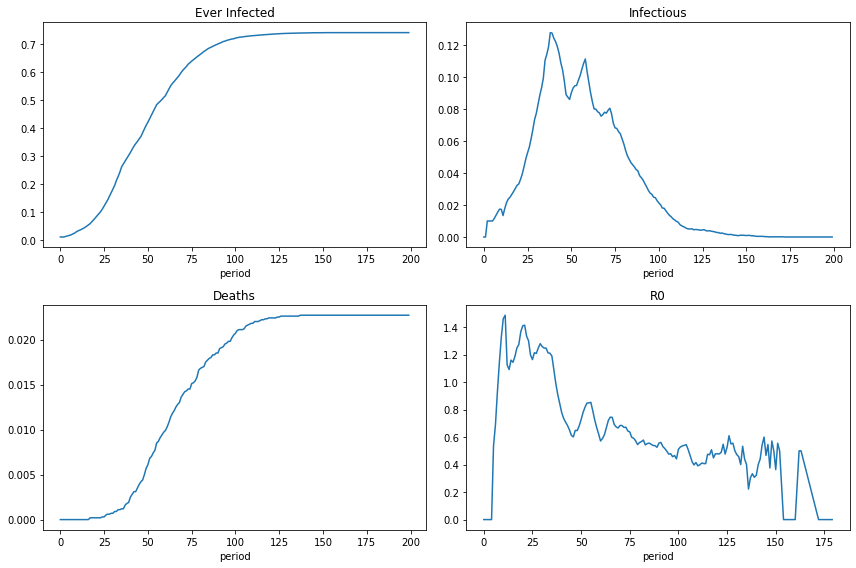

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("period").ever_infected.mean().plot(ax=axs[0])
df.groupby("period").infectious.mean().plot(ax=axs[1])
df.groupby("period").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("period").infection_counter.mean().plot(ax=axs[3])

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")

fig.tight_layout()